In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
import glob
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score


In [2]:
folder_path="C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/Class_L_L/L_L_FEATURES/"
files = os.listdir(folder_path)

file_path=[]
csvfiles=[]
# Iterate through each file
for file in files:
    # Create the absolute path of the file
    file_path.append(os.path.join(folder_path, file))
#print(file_path[1])

for i in file_path:
    csvfiles.append(pd.read_csv(i))
print(csvfiles)

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(csvfiles[5][['RT']],csvfiles[5][['mz']],s=2)
# plt.show()
#print(csvfiles[0][['RT','mz']])
#     # Check if the path is a file (not a directory)
# for i in range(len(file_path)):
#     if os.path.isfile(i):
#         # Read the file contents
#         with open(i, 'r') as f:
#             contents = f.read()
#             # Process the file contents as desired
#             print(contents)

[                 feature_id peptide_sequence  peptide_score ID_filename  \
0       7824516127477318561             None            NaN        None   
1       2833402173127023518             None            NaN        None   
2       3584105666006860450             None            NaN        None   
3       3236426940903996542             None            NaN        None   
4      13968718414037055507             None            NaN        None   
...                     ...              ...            ...         ...   
48359  17692242579154914811             None            NaN        None   
48360  14245534933568202430             None            NaN        None   
48361  15217590542929036366             None            NaN        None   
48362  13159352137877410242             None            NaN        None   
48363   6790395557460457612             None            NaN        None   

      ID_native_id  charge           RT          mz  RTstart    RTend  \
0             None       

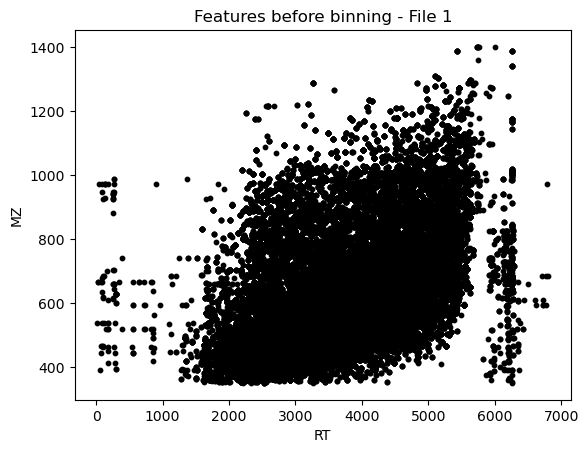

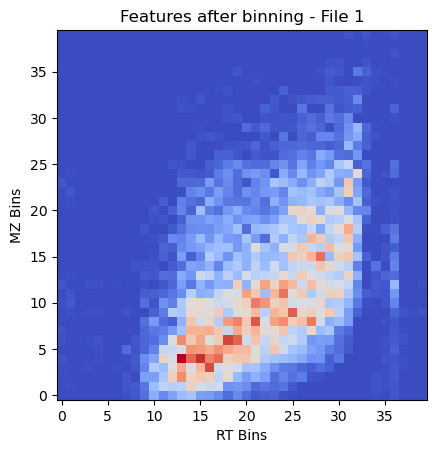

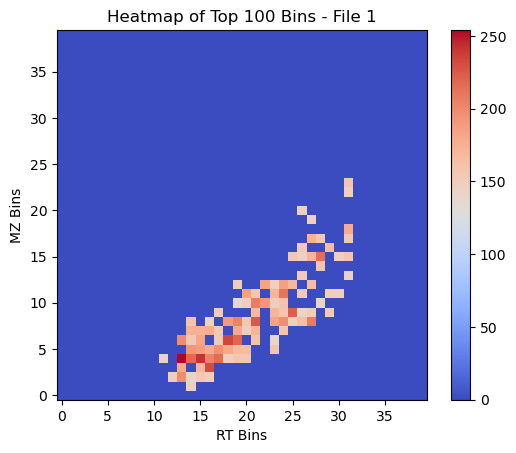

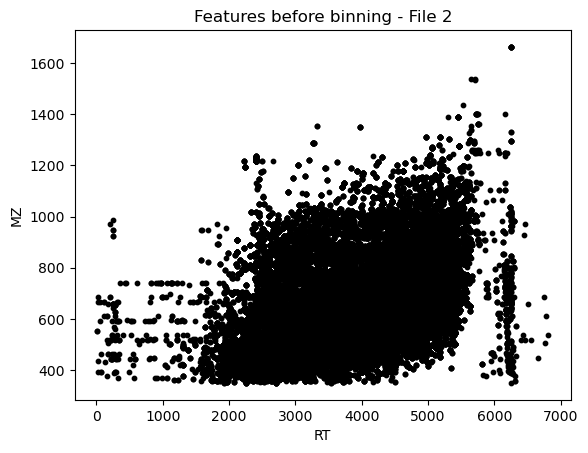

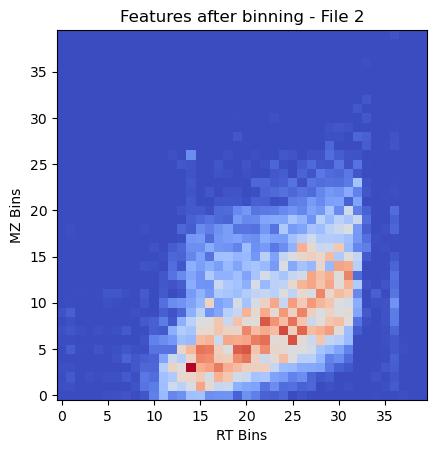

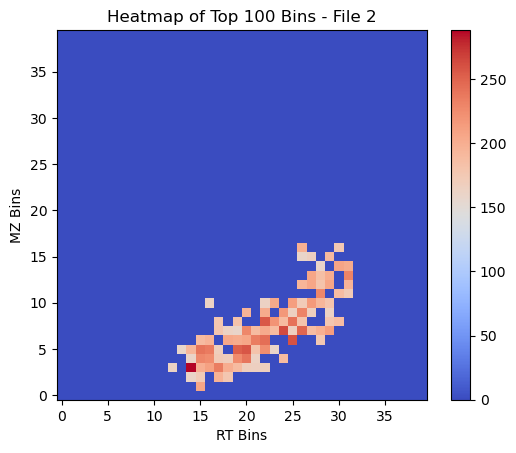

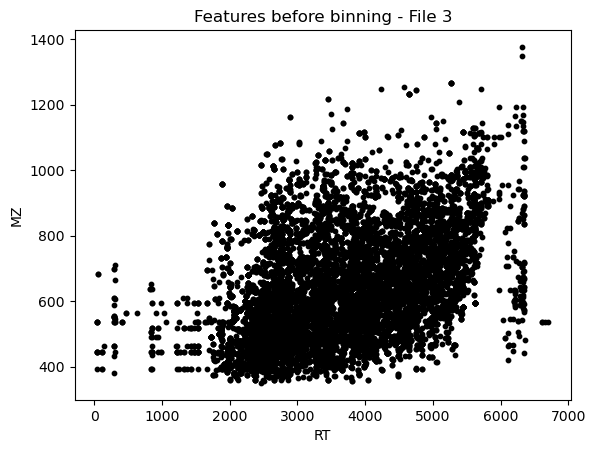

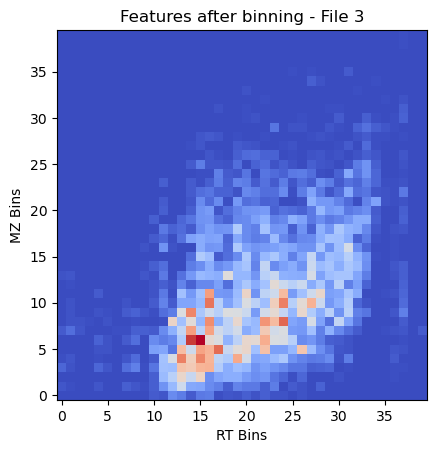

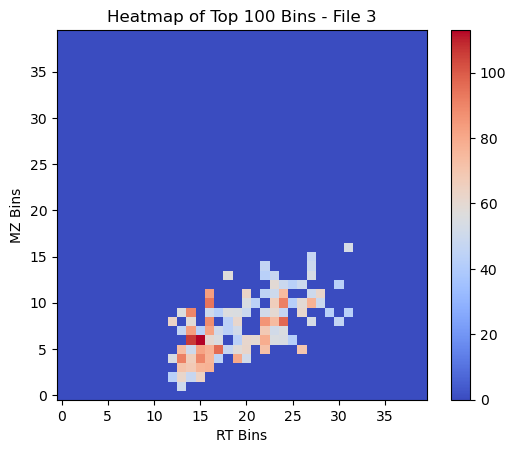

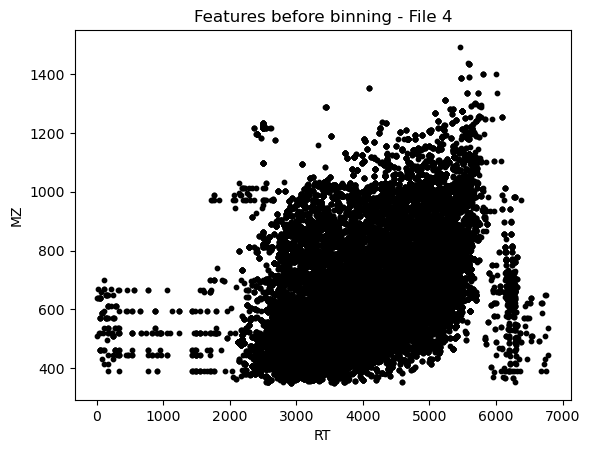

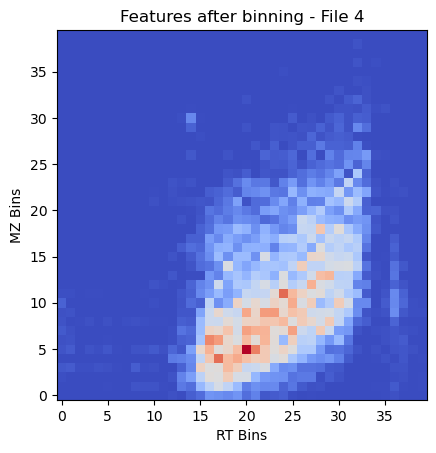

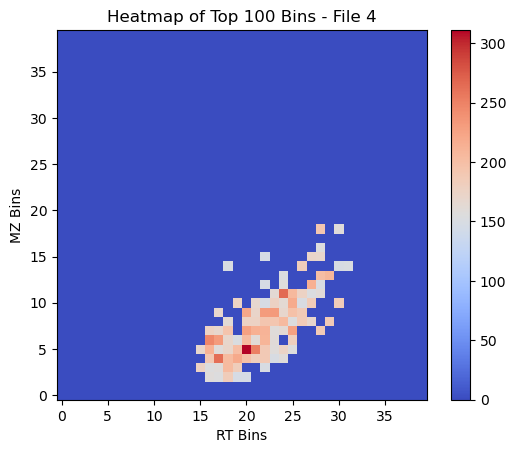

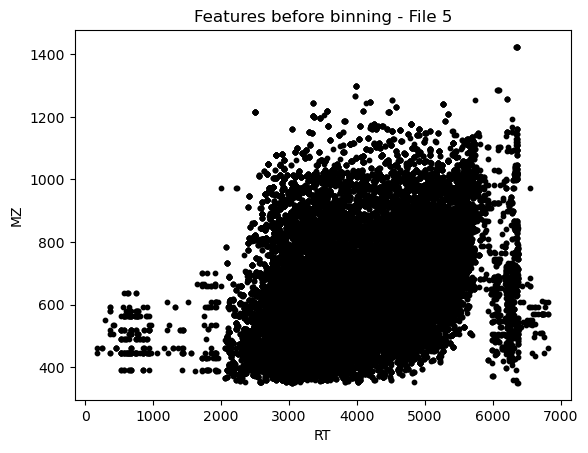

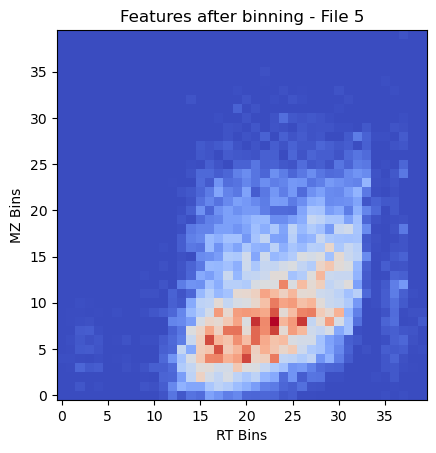

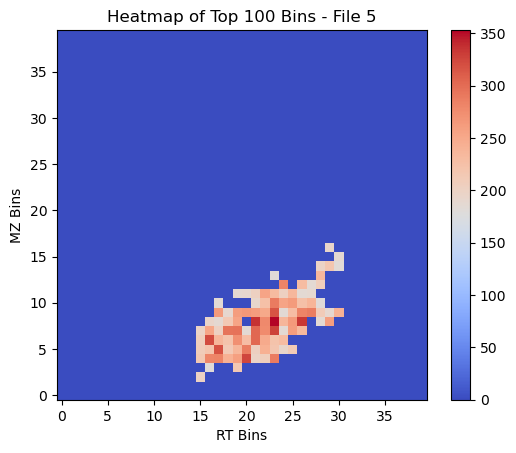

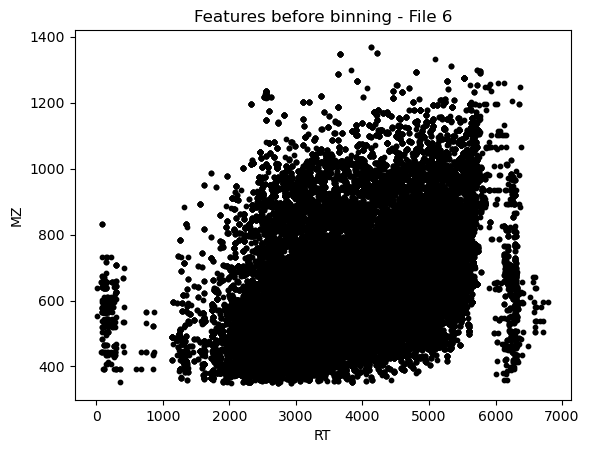

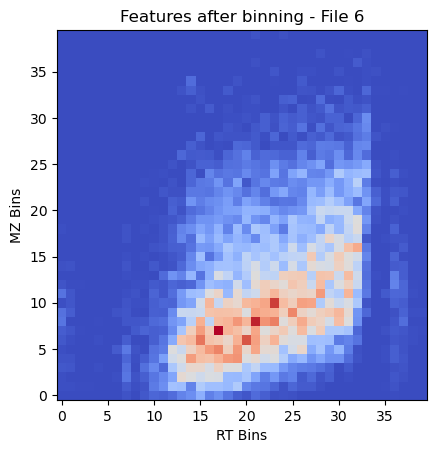

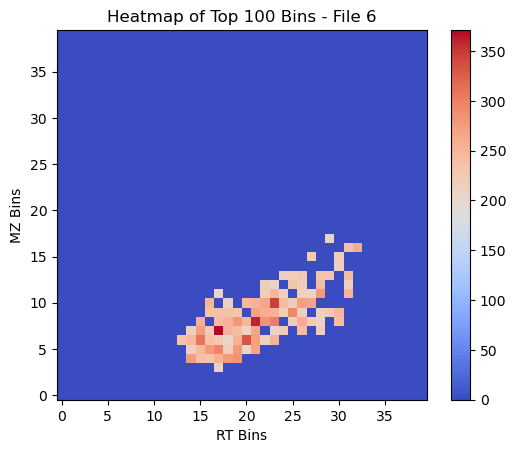

In [3]:
folder_path = "C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/Class_L_L/L_L_FEATURES/"
i = 1
imp_data_pts =[]

for file_path in glob.glob(folder_path + "*.csv"):
    features_H_H = pd.read_csv(file_path)
    RT = features_H_H['RT']
    MZ = features_H_H['mz']
    plt.scatter(RT, MZ, s=10, c='black')
    plt.xlabel('RT')
    plt.ylabel('MZ')
    plt.title(f'Features before binning - File {i}')
    plt.show()

    min_RT = min(RT)
    max_RT = max(RT)
    min_MZ = min(MZ)
    max_MZ = max(MZ)

    RT_nbins = 40
    MZ_nbins = 40
    RT_binsize = (max_RT - min_RT) / RT_nbins
    MZ_binsize = (max_MZ - min_MZ) / MZ_nbins

    rt_ind = np.floor((RT - min_RT) / RT_binsize).astype(int)
    mz_ind = np.floor((MZ - min_MZ) / MZ_binsize).astype(int)

    histogram_2d, _, _ = np.histogram2d(rt_ind, mz_ind, bins=(RT_nbins, MZ_nbins))

    plt.imshow(histogram_2d.T, cmap='coolwarm', origin='lower')  
    plt.xlabel('RT Bins')
    plt.ylabel('MZ Bins')
    plt.title(f'Features after binning - File {i}')
    plt.show()
    
    # Find the indices of the top 30 bins based on count
    top_indices = np.argsort(-histogram_2d, axis=None)[:100]

    # Convert the flat indices to 2D indices
    top_indices_2d = np.unravel_index(top_indices, histogram_2d.shape)

    # Create a mask for the top bins
    top_bins_mask = np.zeros_like(histogram_2d, dtype=bool)
    top_bins_mask[top_indices_2d] = True

    # Apply the mask to retain only the top bins in the heatmap
    heatmap_data = np.where(top_bins_mask, histogram_2d, 0)

    plt.imshow(heatmap_data.T, cmap='coolwarm', origin='lower')
    plt.colorbar()
    plt.title(f'Heatmap of Top 100 Bins - File {i}')
    plt.xlabel('RT Bins')
    plt.ylabel('MZ Bins')
    plt.show()

    top_data_points = []
    for rt_bin, mz_bin in zip(top_indices_2d[0], top_indices_2d[1]):
        mask = (rt_ind == rt_bin) & (mz_ind == mz_bin)
        data_points = np.column_stack((RT[mask], MZ[mask]))
        top_data_points.append(data_points)
    
    imp_data_pts.append(np.concatenate(top_data_points))
    i = i+1

In [4]:
for i in range(len(imp_data_pts)):
    first_column = imp_data_pts[i][:, 0]  # Select the first column
    imp_data_pts[i][:, 0] = [round(value) for value in first_column]  # Round the values to two decimal places
    print(imp_data_pts[i][:, 0])
    


[2310. 2310. 2310. ... 3407. 3408. 3305.]
[2445. 2516. 2516. ... 2388. 2225. 2292.]
[2639. 2639. 2639. ... 4359. 4223. 4264.]
[3423. 3423. 3423. ... 3750. 3825. 3829.]
[4029. 4029. 4029. ... 4918. 4877. 4908.]
[3060. 3060. 3060. ... 3569. 3525. 3475.]


In [6]:
#rt_avgmv=[]

# for i in range(len(imp_data_pts[0])):
#     print(imp_data_pts[0][i,:])

rt_avgmv = []

for imp_data in imp_data_pts:
    # Get unique RT values
    unique_rt_values = np.unique(imp_data[:, 0])

    # Initialize an array to store the averaged data
    averaged_data = np.zeros((len(unique_rt_values), 2))

    # Calculate average MV values for each unique RT value
    for i, rt in enumerate(unique_rt_values):
        averaged_data[i, 0] = rt
        averaged_data[i, 1] = np.mean(imp_data[imp_data[:, 0] == rt, 1])

    rt_avgmv.append(averaged_data)
    print(averaged_data)

print(len(rt_avgmv[0]))
print(len(imp_data_pts[0]))

[[1900.          460.27902222]
 [1905.          471.44352722]
 [1906.          480.74210612]
 ...
 [5445.          856.89981683]
 [5446.          843.61728923]
 [5447.          755.90907796]]
[[2068.          473.22888184]
 [2069.          473.23566437]
 [2089.          459.71156311]
 ...
 [5449.          775.51396688]
 [5450.          825.44970703]
 [5451.          824.96295166]]
[[2058.          571.37447811]
 [2059.          571.38121295]
 [2062.          558.88405211]
 ...
 [5355.          772.390625  ]
 [5356.          775.4052124 ]
 [5371.          767.87357307]]
[[2554.          488.10981097]
 [2555.          514.28167725]
 [2556.          481.19107056]
 ...
 [5410.          777.8951416 ]
 [5423.          766.21538068]
 [5429.          777.92810059]]
[[2666.          536.41906738]
 [2667.          489.76795044]
 [2669.          538.58764648]
 ...
 [5319.          752.19241333]
 [5320.          730.91372681]
 [5321.          616.29119873]]
[[2217.          521.3108521 ]
 [2227.  

In [7]:
flattened_array=[]
flattened_array.append([arr.flatten() for arr in imp_data_pts])
print(len(flattened_array[0][0]))
print(len(flattened_array[0][1]))
print(len(flattened_array[0][2]))
print(len(flattened_array[0][3]))
print(len(flattened_array[0][4]))
print(len(flattened_array[0][5]))

34086
39440
12246
36558
47418
48834


In [8]:
min_length = min(len(arr) for arr in flattened_array[0])
#print(min_length)
subset_arrays = [arr[:min_length] for arr in flattened_array[0]]

print(subset_arrays)
print(subset_arrays[0].size)
print(subset_arrays[1].size)
print(subset_arrays[2].size)
print(subset_arrays[3].size)
print(subset_arrays[4].size)
print(subset_arrays[5].size)

[array([2310.        ,  462.24624634, 2310.        , ...,  453.2401123 ,
       2244.        ,  451.25430298]), array([2445.        ,  449.99850464, 2516.        , ...,  610.30059814,
       5100.        ,  581.33258057]), array([2639.        ,  507.23400879, 2639.        , ...,  615.86590576,
       4264.        ,  609.29949951]), array([3423.        ,  517.25445557, 3423.        , ...,  622.33935547,
       4341.        ,  616.97039352]), array([4029.        ,  565.79223633, 4029.        , ...,  565.64294434,
       3875.        ,  578.81054688]), array([3060.       ,  544.6087036, 3060.       , ...,  620.3832397,
       4719.       ,  622.3148193])]
12246
12246
12246
12246
12246
12246


In [12]:
sub_ar_h=pd.read_csv("C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/1.csv")
sub_ar_l=pd.read_csv("C:/Users/bless/OneDrive/MS_Studies/AML/proteomics/L_Loutput.csv")
sub_ar_l['class']=0
sub_ar_l

,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,2310.0,462.246246,2310.0,462.247528,2310.0,462.244934,2331.0,477.257629,2331.0,457.757904,...,430.229797,2289.0,445.720886,2373.0,444.567474,2251.0,453.240112,2244.0,451.254303,0
1,2445.0,449.998505,2516.0,475.751678,2516.0,475.753052,2430.0,462.246246,2430.0,462.247528,...,579.966370,5042.0,583.281677,5100.0,580.856018,5086.0,610.300598,5100.0,581.332581,0
2,2639.0,507.234009,2639.0,507.232452,2639.0,507.230896,2580.0,515.757446,2580.0,515.759094,...,626.765808,4330.0,630.890137,4359.0,630.307517,4223.0,615.865906,4264.0,609.299500,0
3,3423.0,517.254456,3423.0,517.256042,3423.0,517.757324,3414.0,510.246094,3414.0,510.247681,...,607.837952,4251.0,628.834290,4348.0,614.839417,4249.0,622.339355,4341.0,616.970394,0
4,4029.0,565.792236,4029.0,565.790283,4029.0,565.794128,4099.0,567.655884,4120.0,567.318420,...,578.814636,3976.0,565.637146,3879.0,573.803467,3976.0,565.642944,3875.0,578.810547,0
5,3060.0,544.608704,3060.0,544.606934,3060.0,544.610535,3060.0,544.612305,2895.0,543.325440,...,624.341065,4672.0,617.843384,4728.0,609.632507,4716.0,620.383240,4719.0,622.314819,0


In [13]:
sub_ar_h=sub_ar_h.iloc[:, :12247]
sub_ar_h['class']=1
sub_ar_h = sub_ar_h.drop("Unnamed: 0", axis=1)


In [14]:
#sub_ar_h
sub_array=pd.concat([sub_ar_h,sub_ar_l],axis=0)
sub_array

,0,1,2,3,4,5,6,7,8,9,...,12237,12238,12239,12240,12241,12242,12243,12244,12245,class
0,3768.215901,584.854065,3768.205167,584.851990,3783.715845,567.654785,3783.830196,567.656738,3787.563605,558.326965,...,588.305127,4424.223611,594.955933,4398.187511,590.343689,4283.559876,601.830994,4316.270735,608.330688,1
1,2797.307919,442.953674,2797.259292,442.954834,2733.689379,449.747192,2797.177762,442.956024,2733.659331,449.748413,...,558.283508,3820.718520,577.265259,3891.882512,577.818848,3868.193308,580.304749,3785.522061,567.812927,1
2,3337.142956,510.246094,3337.398619,510.244507,3336.791641,510.247681,3337.444891,510.242950,3327.188272,517.256042,...,601.294006,4496.664894,608.848938,4541.772104,599.651672,4461.967576,607.676880,4565.202366,600.362549,1
3,3452.686071,510.246094,3453.036993,510.244507,3452.231348,510.247681,3453.323141,510.242950,3494.949350,517.254456,...,629.849121,4133.766005,634.833374,4116.836262,633.851135,4098.593878,638.872009,4104.290957,639.864929,1
4,3935.494383,638.852234,3935.503446,638.849792,3949.110655,638.852234,3935.493997,638.854736,3949.158326,638.854736,...,764.420959,5126.976047,774.461365,5232.850052,764.891968,5159.438800,777.895142,5137.436475,780.912292,1
5,3311.814266,571.822021,3311.783381,571.820068,3311.840220,571.824036,3311.752108,571.818115,3383.196984,575.848877,...,568.827393,4171.685555,577.355225,4163.593596,564.783813,4226.568892,577.282532,4238.956042,565.313721,1
0,2310.000000,462.246246,2310.000000,462.247528,2310.000000,462.244934,2331.000000,477.257629,2331.000000,457.757904,...,430.229797,2289.000000,445.720886,2373.000000,444.567474,2251.000000,453.240112,2244.000000,451.254303,0
1,2445.000000,449.998505,2516.000000,475.751678,2516.000000,475.753052,2430.000000,462.246246,2430.000000,462.247528,...,579.966370,5042.000000,583.281677,5100.000000,580.856018,5086.000000,610.300598,5100.000000,581.332581,0
2,2639.000000,507.234009,2639.000000,507.232452,2639.000000,507.230896,2580.000000,515.757446,2580.000000,515.759094,...,626.765808,4330.000000,630.890137,4359.000000,630.307517,4223.000000,615.865906,4264.000000,609.299500,0
3,3423.000000,517.254456,3423.000000,517.256042,3423.000000,517.757324,3414.000000,510.246094,3414.000000,510.247681,...,607.837952,4251.000000,628.834290,4348.000000,614.839417,4249.000000,622.339355,4341.000000,616.970394,0


In [15]:
X = sub_array.drop("class", axis=1)
Y = sub_array[["class"]].copy()
# print(X)
# print(Y)

In [16]:
oversampler = RandomOverSampler(sampling_strategy={0: 100, 1: 100})  # Set the desired number of samples for each class

# Perform the oversampling
oversampled_data, oversampled_labels = oversampler.fit_resample(X, Y)
oversampled_data

noise_factor = 0.05  # Adjust this value as per your requirement
noisy_oversampled_data = oversampled_data + np.random.normal(0, noise_factor, size=oversampled_data.shape)

# The noisy_oversampled_data now contains the oversampled data with slight variations

# Print the oversampled data
oversampled_data=noisy_oversampled_data
print(oversampled_data)
print(oversampled_labels)
# # Define the custom sampling strategy function
# def custom_sampling_strategy(y):
#     class_counts = np.bincount(y)
#     minority_class = np.argmin(class_counts)
#     majority_class = np.argmax(class_counts)
#     desired_samples = class_counts[majority_class]  # Set desired samples equal to the majority class count

#     # Create a dictionary for sampling strategy
#     sampling_strategy = {}
#     for class_label, count in enumerate(class_counts):
#         if class_label == minority_class:
#             sampling_strategy[class_label] = desired_samples
#         else:
#             sampling_strategy[class_label] = desired_samples - (class_counts[majority_class] - count)

#     return sampling_strategy

# # Create the RandomOverSampler with the custom sampling strategy
# oversampler = RandomOverSampler(sampling_strategy=custom_sampling_strategy)

# # Resample the data
# X_resampled, y_resampled = oversampler.fit_resample(X, Y)
# X_resampled
# #print(y_resampled)

C:\Users\bless\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (100) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6)
  warnings.warn(
C:\Users\bless\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (100) in class 1 will be larger than the number of samples in the majority class (class #0 -> 6)
  warnings.warn(


               0           1            2           3            4  \
0    3768.203427  584.832964  3768.254679  584.880763  3783.670754   
1    2797.302232  442.877024  2797.160563  442.919104  2733.710114   
2    3337.138054  510.283720  3337.377398  510.222022  3336.784252   
3    3452.590220  510.234930  3453.029103  510.267230  3452.130182   
4    3935.474370  638.870951  3935.633226  638.940982  3949.055810   
..           ...         ...          ...         ...          ...   
195  3768.248612  584.871475  3768.227088  584.773641  3783.755850   
196  3452.719775  510.213832  3453.026168  510.270077  3452.193732   
197  3311.853188  571.854047  3311.869355  571.937205  3311.811312   
198  3311.803878  571.822626  3311.762895  571.858494  3311.778177   
199  3337.109312  510.252273  3337.369078  510.255938  3336.686032   

              5            6           7            8           9  ...  \
0    567.705607  3783.816804  567.609437  3787.512024  558.283762  ...   
1    449.69

In [17]:
scaler=StandardScaler()
X_array=oversampled_data.values
scaleX=scaler.fit_transform(X_array)
Scale_X=pd.DataFrame(scaleX,columns=X.columns)
    

In [18]:
Scale_X

,0,1,2,3,4,5,6,7,8,9,...,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245
0,1.113820,1.106284,1.119142,1.118549,1.140233,0.834670,1.115019,0.823782,1.095920,0.640093,...,0.317367,-0.042638,0.311455,-0.050132,0.228407,-0.045218,0.128506,0.008101,0.156135,0.169386
1,-0.676792,-1.440018,-0.700680,-1.560469,-0.804955,-1.473920,-0.663312,-1.585358,-0.751583,-1.416177,...,-0.386927,-0.451265,-0.509680,-0.295592,-0.459677,-0.225780,-0.425701,-0.300081,-0.540546,-0.394755
2,0.318815,-0.230926,0.311682,-0.290368,0.312318,-0.288303,0.310464,-0.287224,0.288814,-0.135726,...,0.401605,0.136857,0.409977,0.145287,0.423792,0.085278,0.366597,0.090266,0.482910,0.059058
3,0.531741,-0.231801,0.528412,-0.289514,0.526011,-0.289191,0.519307,-0.286961,0.583079,-0.136376,...,-0.082909,0.527460,-0.083868,0.507552,-0.153907,0.576493,-0.118305,0.536103,-0.122179,0.609933
4,1.422314,2.075579,1.432808,2.138742,1.446630,2.227096,1.388431,2.200832,1.379229,2.164982,...,1.397431,2.370353,1.267593,2.455966,1.362950,2.451647,1.297361,2.516914,1.234026,2.579529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.113903,1.106975,1.119090,1.116527,1.140390,0.834646,1.115141,0.824243,1.095977,0.640752,...,0.317174,-0.041574,0.311397,-0.050242,0.228587,-0.047827,0.128430,0.006383,0.156222,0.169689
196,0.531980,-0.232180,0.528407,-0.289461,0.526129,-0.289632,0.519393,-0.285068,0.583198,-0.138181,...,-0.082972,0.526416,-0.083736,0.506708,-0.153846,0.576517,-0.118404,0.534571,-0.122192,0.610089
197,0.272183,0.873478,0.263880,0.874286,0.266052,0.914875,0.264055,0.905258,0.387155,0.972466,...,-0.074863,-0.307745,-0.032248,-0.295165,-0.090276,-0.413309,0.052568,-0.342201,0.054790,-0.430786
198,0.272092,0.872914,0.263680,0.872800,0.265991,0.916012,0.264164,0.904558,0.387027,0.973116,...,-0.074778,-0.308183,-0.032101,-0.292906,-0.090322,-0.414488,0.052508,-0.342184,0.054640,-0.430151


In [19]:

Y=LabelEncoder().fit_transform(oversampled_labels)
X_train,X_test,Y_train,Y_test=train_test_split(Scale_X,Y,test_size=1/3,stratify=Y,random_state=0)

print(X_train)
    

            0         1         2         3         4         5         6  \
130  1.422371  2.076251  1.432497  2.136581  1.446778  2.227413  1.388405   
118  0.272057  0.873053  0.263753  0.870502  0.266179  0.913990  0.264178   
178  0.531933 -0.229646  0.528564 -0.290038  0.526176 -0.290839  0.519420   
5    0.272156  0.873928  0.263689  0.872219  0.266166  0.915189  0.264195   
172  1.113815  1.106879  1.119089  1.117744  1.140481  0.834570  1.115113   
..        ...       ...       ...       ...       ...       ...       ...   
33  -0.968831 -0.285388 -0.997007 -0.346318 -0.980273 -0.347180 -1.054781   
61   1.594835  0.763382  1.607815  0.757622  1.594753  0.796517  1.683282   
129 -0.676793 -1.439132 -0.700504 -1.560577 -0.805172 -1.473402 -0.663324   
51   1.594941  0.764669  1.607799  0.757817  1.594832  0.798315  1.682968   
156  1.113705  1.105397  1.119151  1.117076  1.140316  0.834922  1.115340   

            7         8         9  ...     12236     12237     12238  \
130

C:\Users\bless\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
print(X_test)

            0         1         2         3         4         5         6  \
132  0.209276  0.933529  0.198612  0.936645  0.204725  0.990838  0.195672   
76   1.510573  0.823684  1.524692  0.819564  1.513334  0.867620  1.579395   
189  0.209344  0.935131  0.198770  0.936273  0.204947  0.988841  0.195553   
20  -1.011179 -0.242142 -1.045179 -0.313917 -1.022817 -0.320475 -1.090560   
143  0.255289 -0.189251  0.245842 -0.255185  0.250485 -0.256605  0.240737   
..        ...       ...       ...       ...       ...       ...       ...   
101 -1.363386 -1.288878 -1.272474 -0.923409 -1.247442 -0.957611 -1.354261   
38  -1.011412 -0.243260 -1.045174 -0.313263 -1.023006 -0.319350 -1.090445   
158  0.464883 -0.190126  0.459864 -0.255642  0.460845 -0.257744  0.444548   
0    1.037391  1.173098  1.042456  1.189333  1.065769  0.904414  1.025456   
83  -1.363322 -1.290190 -1.272672 -0.922634 -1.247374 -0.956297 -1.354255   

            7         8         9  ...     12236     12237     12238  \
132

In [75]:
print(len(Y_train))

133


In [ ]:
#ADABOOST
n_estimators_list = [50, 250, 500, 750]
for n_estimators in n_estimators_list:
    # Initialize the AdaBoost Classifier
    ada_classifier = AdaBoostClassifier(n_estimators=n_estimators, random_state=1) #THIS ONE TAKES A LOOOOOOT OF TIME

    # Fit the classifier on the training data
    ada_classifier.fit(X_train, Y_train)

    # Predict probabilities on the test data
    probs = ada_classifier.predict_proba(X_test)

    # Extract the probabilities of the positive class
    positive_class_probs = probs[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(Y_test, positive_class_probs)

    print('Number of estimators:', n_estimators)
    print('AUC score:', auc_score)
    print('---------------------------------------------------------')
        

Number of estimators: 50
AUC score: 1.0
---------------------------------------------------------


In [17]:
adaboost = AdaBoostClassifier(n_estimators=500, random_state=14)
adaboost.fit(X_train, Y_train)
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
probabilities_train = cross_val_predict(adaboost, X_train, Y_train, cv=kfold, method='predict_proba')

In [18]:
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]
print(Y_pred_train)
print(Y_train)

[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
[1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1]


In [19]:
# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_train, Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000


In [20]:
ada=adaboost.fit(X_train, Y_train)
test_pro=ada.predict_proba(X_test)

In [21]:
test_pro
Y_pred_test = [0 if p[0] > 0.5 else 1 for p in test_pro]
print(Y_pred_test)
print(">>>>>>>>>>>>>>>>>>>>>>>>>")
print(Y_test)

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
>>>>>>>>>>>>>>>>>>>>>>>>>
[1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0]


In [22]:
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
recall = recall_score(Y_test, Y_pred_test)
f1 = f1_score(Y_test, Y_pred_test)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000


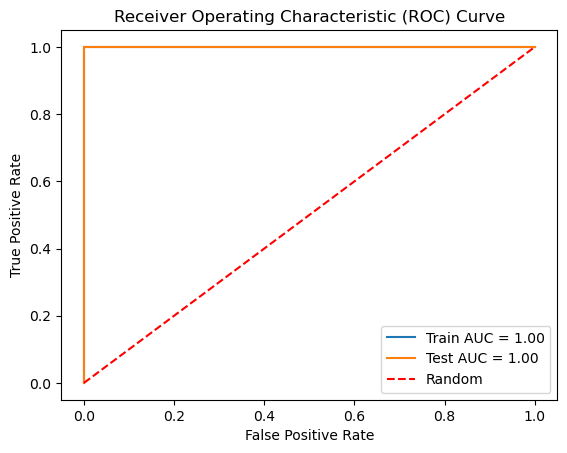

In [23]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, Y_pred_train)
auc_train = roc_auc_score(Y_train, Y_pred_train)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, Y_pred_test)
auc_test = roc_auc_score(Y_test, Y_pred_test)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [20]:
#XGBOOST
n_estimators_list = [10, 50, 75, 100, 250, 500, 750]

for est in n_estimators_list:
    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=est, random_state=1)

    # Fit the classifier on the training data
    xgb_classifier.fit(X_train, Y_train)

    # Predict probabilities on the test data
    X_probs = xgb_classifier.predict_proba(X_test)

    # Extract the probabilities of the positive class
    X_positive_class_probs = X_probs[:, 1]

    # Calculate the AUC score
    X_auc_score = roc_auc_score(Y_test, X_positive_class_probs)

    print('Number of estimators:', est)
    print('AUC score:', X_auc_score)
    print('---------------------------------------------------------')

   

        

Number of estimators: 10
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 50
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 75
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 100
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 250
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 500
AUC score: 1.0
---------------------------------------------------------
Number of estimators: 750
AUC score: 1.0
---------------------------------------------------------


In [21]:
xgb_classifier = xgb.XGBClassifier(n_estimators=500, random_state=14)
xgb_classifier.fit(X_train, Y_train)
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
X_probabilities_train = cross_val_predict(xgb_classifier, X_train, Y_train, cv=kfold, method='predict_proba')

In [23]:
X_Y_pred_train = [0 if p[0] > 0.5 else 1 for p in X_probabilities_train]
print(X_Y_pred_train)
print(Y_train)

[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
[1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1]


In [24]:
# Calculate scores
accuracy = accuracy_score(Y_train, X_Y_pred_train)
precision = precision_score(Y_train, X_Y_pred_train)
recall = recall_score(Y_train, X_Y_pred_train)
f1 = f1_score(Y_train, X_Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000


In [25]:
xgb=xgb_classifier.fit(X_train, Y_train)
X_test_pro=xgb.predict_proba(X_test)

In [27]:
X_test_pro
X_Y_pred_test = [0 if p[0] > 0.5 else 1 for p in X_test_pro]
print(X_Y_pred_test)
print(">>>>>>>>>>>>>>>>>>>>>>>>>")
print(Y_test)

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
>>>>>>>>>>>>>>>>>>>>>>>>>
[1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0]


In [28]:
accuracy = accuracy_score(Y_test, X_Y_pred_test)
precision = precision_score(Y_test, X_Y_pred_test)
recall = recall_score(Y_test, X_Y_pred_test)
f1 = f1_score(Y_test, X_Y_pred_test)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000


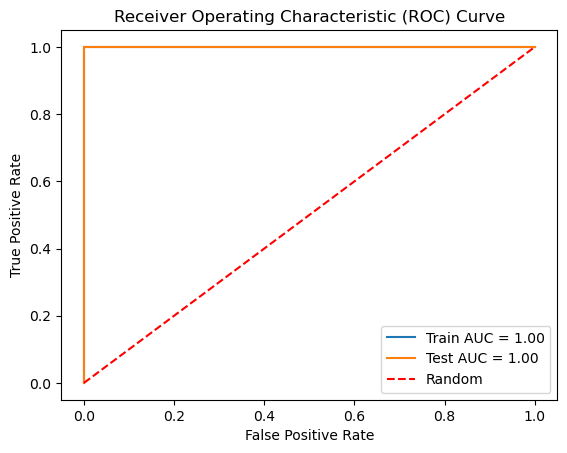

In [29]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, X_Y_pred_train)
auc_train = roc_auc_score(Y_train, X_Y_pred_train)

# For test set
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, X_Y_pred_test)
auc_test = roc_auc_score(Y_test, X_Y_pred_test)

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()